In [68]:
import pandas as pd
import numpy as np
import os
import warnings
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import math
import calendar
from matplotlib import pyplot as plt
%pylab inline
warnings.filterwarnings("ignore")
os.chdir(r'''D:\Coursera_ML\Final Project\Data''')

Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### 1. Загружаем данные за январь-май 2016

In [13]:
data_january=pd.read_excel(r'''Grouped_data_january.xlsx''')
data_february=pd.read_excel(r'''Grouped_data_february.xlsx''')
data_march=pd.read_excel(r'''Grouped_data_march.xlsx''')
data_april=pd.read_excel(r'''Grouped_data_april.xlsx''')
data_may=pd.read_excel(r'''Grouped_data_may.xlsx''')

In [14]:
ESB_region=1231
identifiers=pd.read_csv(r'''regions.csv''',engine='python',sep=';')
data=pd.concat([data_january,data_february,data_march,data_april,data_may])

#### 2. Прогноз будет посроен для ячейки с Empire State Building

In [15]:
data_EBS=data[data.region==ESB_region]
data_EBS.index=np.arange(1,len(data_EBS)+1)

Выберем параметр K=5.

In [16]:
K=5
data_EBS['T']=data_EBS.index
for i in range(1,K+1):
    data_EBS['sin_'+str(i)]=np.sin(data_EBS['T']*2*math.pi*i/168)
    data_EBS['cos_'+str(i)]=np.cos(data_EBS['T']*2*math.pi*i/168)

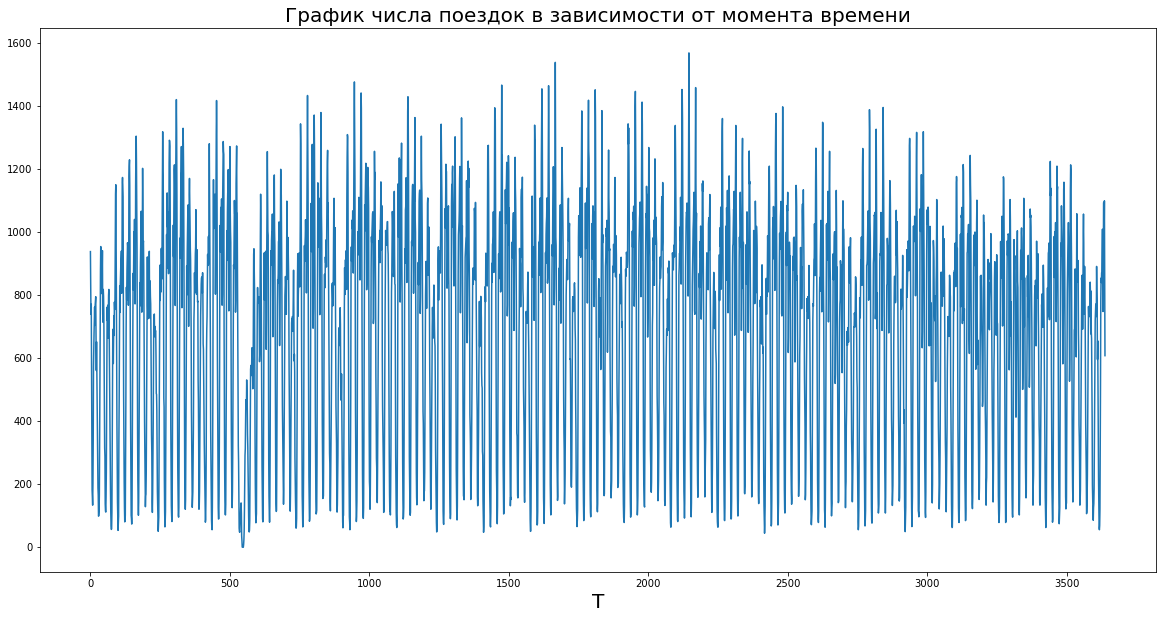

In [17]:
plt.figure(figsize=(20,10))
plt.plot(data_EBS['T'],data_EBS['N_trips'])
plt.title('График числа поездок в зависимости от момента времени',fontsize=20)
plt.xlabel('T',fontsize=20)
plt.show()

Нарисуем STL-декомпозицию целевого ряда.

Критерий Дики-Фуллера для исходного ряда: p=0.000000


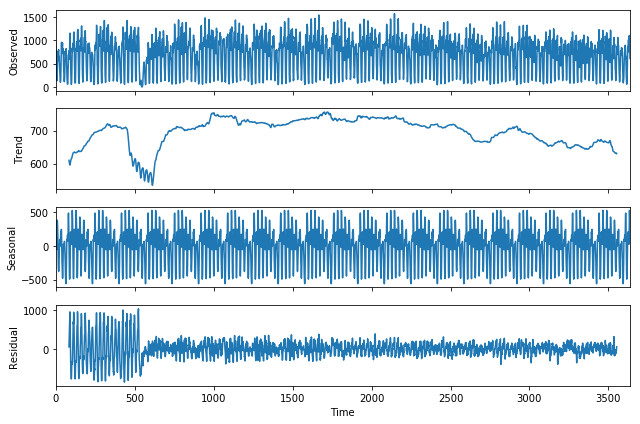

In [99]:

sm.tsa.seasonal_decompose(data_EBS['N_trips'].values,freq=168).plot()
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % sm.tsa.stattools.adfuller(data_EBS['N_trips'].values)[1])

Хотя критерий Дики-Фуллера и отверг гипотезу о нестационарности, сделаем преобразование Бокса-Кокса с оптимальным параметром.

In [19]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))


Критерий Дики-Фуллера для ряда, преобразованного методом Бокса-Кокса: p=0.000000


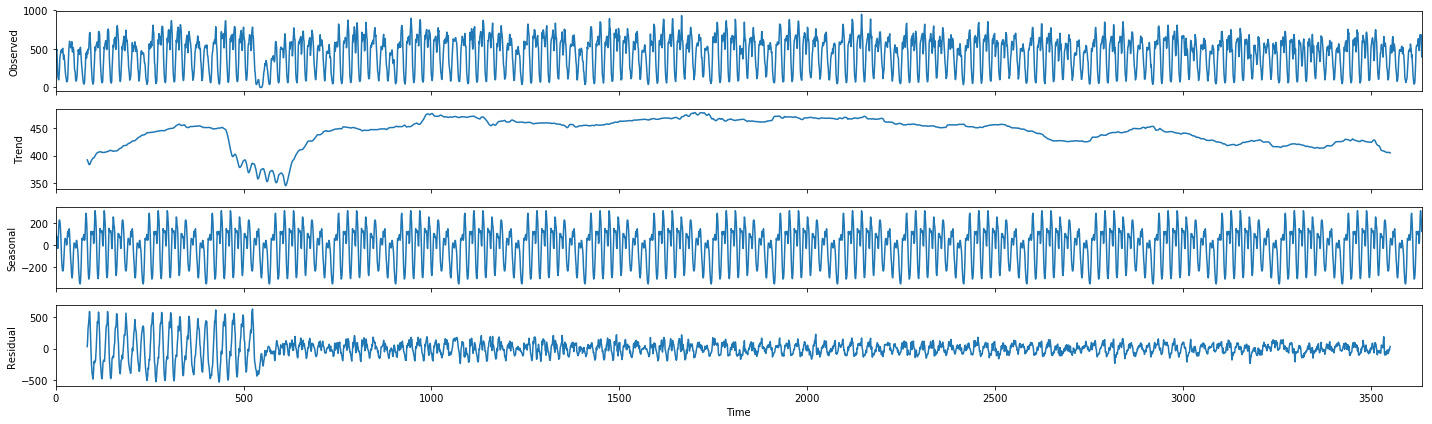

In [97]:
data_EBS['Intercept']=1
data_EBS['box_trips'], lmbda = stats.boxcox(data_EBS.N_trips)
sm.tsa.seasonal_decompose(data_EBS.box_trips.values,freq=168).plot()
print("Критерий Дики-Фуллера для ряда, преобразованного методом Бокса-Кокса: p=%f" % sm.tsa.stattools.adfuller(data_EBS.box_trips)[1])

По всей видимости добавлять тренд не стоит.

Проведем регрессию на периодические признаки и константу, применив преобразование Бокса-Кокса с оптимальным параметром к зависимому ряду.

In [21]:

regression=OLS(endog=data_EBS.box_trips,exog=data_EBS.iloc[:,-12:-1])
res_OLS1=regression.fit()
res_OLS1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              box_trips   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     19.35
Date:                Thu, 25 Oct 2018   Prob (F-statistic):           3.68e-35
Time:                        20:58:35   Log-Likelihood:                -24617.
No. Observations:                3637   AIC:                         4.926e+04
Df Residuals:                    3626   BIC:                         4.932e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1        -49.8768      4.953    -10.069      0.000     -59.588     -40.165
cos_1         23.7045      4.937      4.802      0.000      14.026      33.383
sin_2         23.2629      4.942      4.707      0.000      13.574      32.952
cos_2         10.2121      4.948      2.064      0.039       0.511      19.913
sin_3         -5.5867      4.943     -1.130      0.258     -15.278       4.105
cos_3        -14.0922      4.947     -2.849      0.004     -23.791      -4.393
sin_4         -8.4265      4.947     -1.703      0.089     -18.125       1.272
cos_4         13.3055      4.943      2.692      0.007       3.615      22.997
sin_5         22.8210      4.944      4.616      0.000      13.128      32.514
cos_5          1.8854      4.945      0.381      0.703      -7.810      11.581
Intercept    442.0732      3.497    126.429      0.000     435.218     448.929
==============================================================================
Omnibus:                      651.877   Durbin-Watson:                   0.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              262.045
Skew:                          -0.473   Prob(JB):                     1.25e-57
Kurtosis:                       2.086   Cond. No.                         1.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

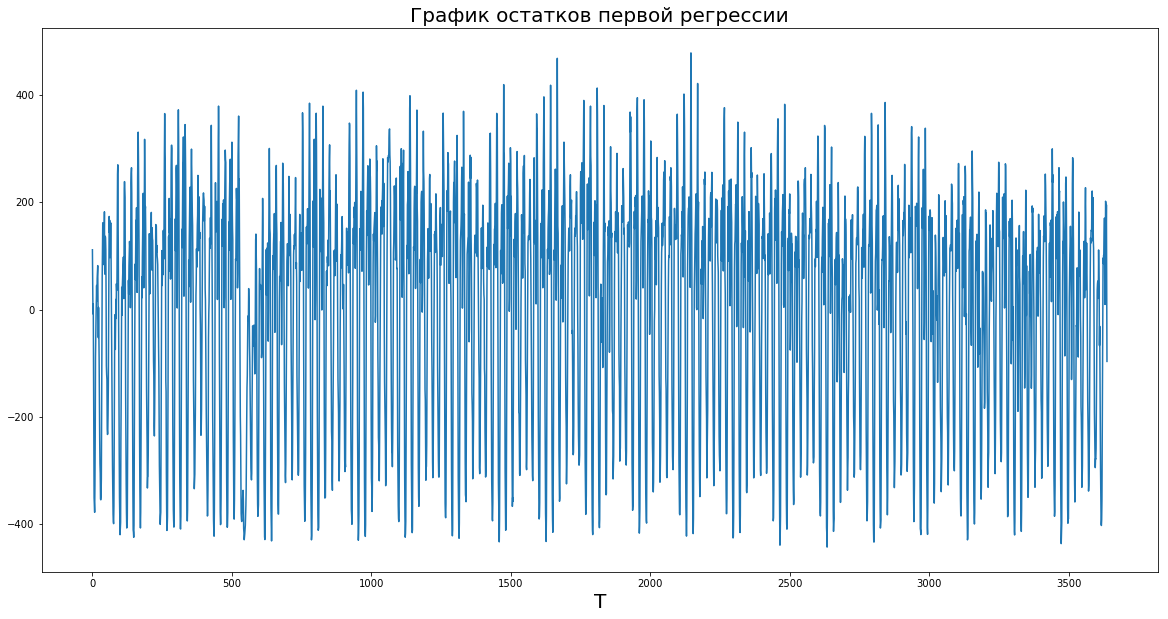

In [22]:
plt.figure(figsize=(20,10))
plt.plot(res_OLS1.resid.index,res_OLS1.resid)
plt.title('График остатков первой регрессии',fontsize=20)
plt.xlabel('T',fontsize=20)
plt.show()

Проверим стационарность ряда остатков первой регрессии.

Критерий Дики-Фуллера для остатков первой регрессии: p=0.000000


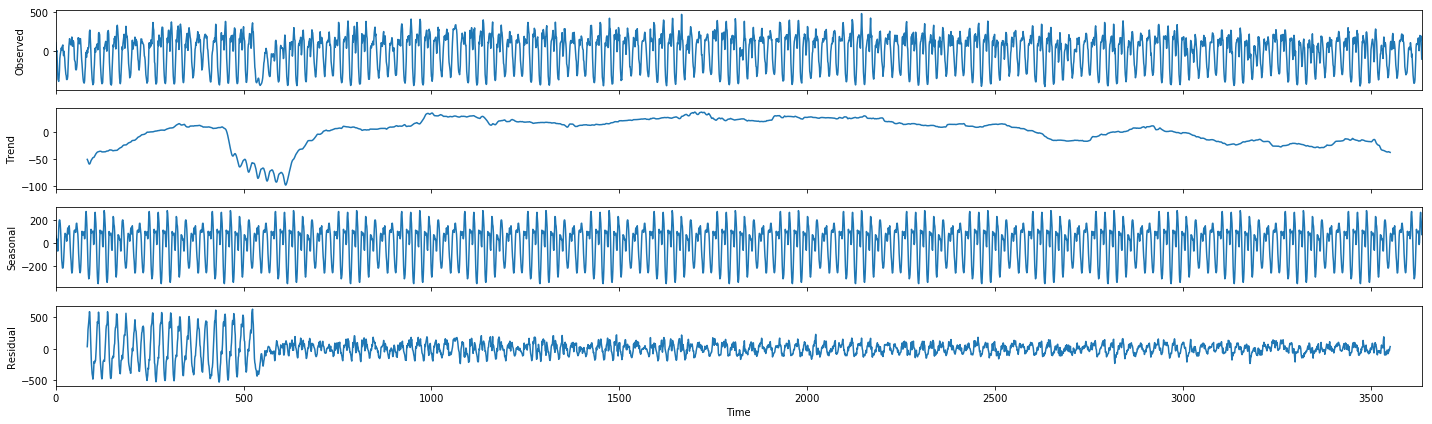

In [96]:
sm.tsa.seasonal_decompose(res_OLS1.resid.values,freq=168).plot()
print("Критерий Дики-Фуллера для остатков первой регрессии: p=%f" % sm.tsa.stattools.adfuller(res_OLS1.resid)[1])

#### 3. Подбор параметров модели.

Построим графики частной и стандартной автокорреляций.

Графики для подбора Q,P


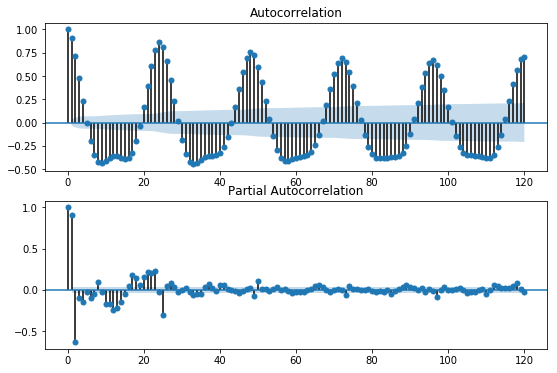

In [24]:
plt.figure(figsize(9,6))
print('Графики для подбора Q,P')
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(res_OLS1.resid.values.squeeze(), lags=24*5, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(res_OLS1.resid.values.squeeze(), lags=24*5, ax=ax)
plt.show()

Графики для подбора q,p


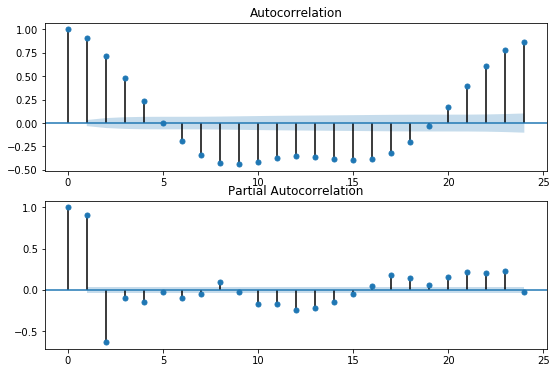

In [25]:
plt.figure(figsize(9,6))
print('Графики для подбора q,p')
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(res_OLS1.resid.values.squeeze(), lags=24, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(res_OLS1.resid.values.squeeze(), lags=24, ax=ax)

plt.show()


Хотя графики подсказывают взять значения побольше, остановимся на P=Q=1 p=q=2.

In [28]:
from itertools import product
ps = range(0, 3)
d=0
qs = range(0, 3)
Ps = range(0, 2)
D=0
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [29]:
%%time
results = []
best_aic = float("inf")

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(endog=data_EBS.box_trips.values,exog=data_EBS.iloc[:,-12:-1].values, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

print(best_model.summary())

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 1, 0, 0)
wrong parameters: (0, 1, 0, 1)
wrong parameters: (0, 1, 1, 0)
wrong parameters: (0, 1, 1, 1)
wrong parameters: (0, 2, 0, 0)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 3637
Model:             SARIMAX(2, 0, 2)x(1, 0, 1, 24)   Log Likelihood              -19509.330
Date:                            Thu, 25 Oct 2018   AIC                          39054.659
Time:                                    21:10:11   BIC                          39166.240
Sample:                                         0   HQIC                         39094.403
                                           - 3637                                         
Covariance Type:                              opg                                   

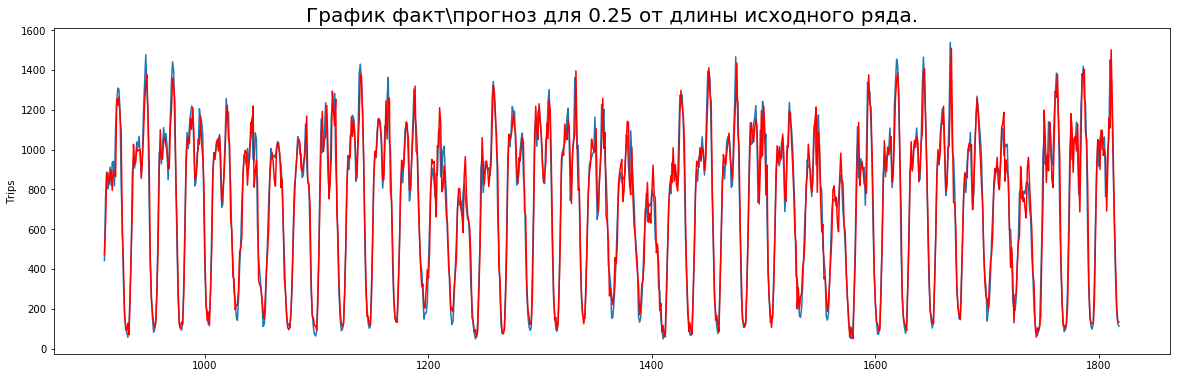

In [86]:
data_EBS['model']=invboxcox(best_model.fittedvalues,lmbda)
plt.figure(figsize(20,6))
data_EBS.N_trips[len(data_EBS)//4:2*len(data_EBS)//4].plot()
data_EBS.model[len(data_EBS)//4:2*len(data_EBS)//4].plot(color='r')
plt.ylabel('Trips')
plt.title('График факт\прогноз для 0.25 от длины исходного ряда.',fontsize=20)
pylab.show()

Видно, что за исключением значений, сильно отклоняющихся от средних, модель неплохо прогнозирует исходный ряд.

Добавим два бинарных признака: первый равен единице, если значение больше медианы целевого ряда и нулю в противном случае, второй - если значение меньше 20% эмпирического квантиля целевого ряда.

In [56]:
med,quant=np.median(data_EBS.N_trips),np.quantile(data_EBS.N_trips,0.2)

In [91]:
data_EBS['med']=data_EBS.N_trips.apply(lambda x: int(x>med))
data_EBS['quant']=data_EBS.N_trips.apply(lambda x: int(x<quant))
new_exog=data_EBS.iloc[:,[x for x in range(4,15)]+[len(data_EBS.columns)-1,len(data_EBS.columns)-2]]

In [92]:
model=sm.tsa.statespace.SARIMAX(endog=data_EBS.box_trips.values,exog=new_exog.values, order=(2, 0, 2), 
                                        seasonal_order=(1, 0, 1, 24)).fit(disp=-1)

In [93]:
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 3637
Model:             SARIMAX(2, 0, 2)x(1, 0, 1, 24)   Log Likelihood              -20632.683
Date:                            Thu, 25 Oct 2018   AIC                          41305.367
Time:                                    22:09:44   BIC                          41429.345
Sample:                                         0   HQIC                         41349.527
                                           - 3637                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -17.0149      2.038     -8.350      0.000     -21.009     -13.021
x2             4.3491      2.000   

Хотя AIC и вырос, нарисуем прогноз по новой модели.

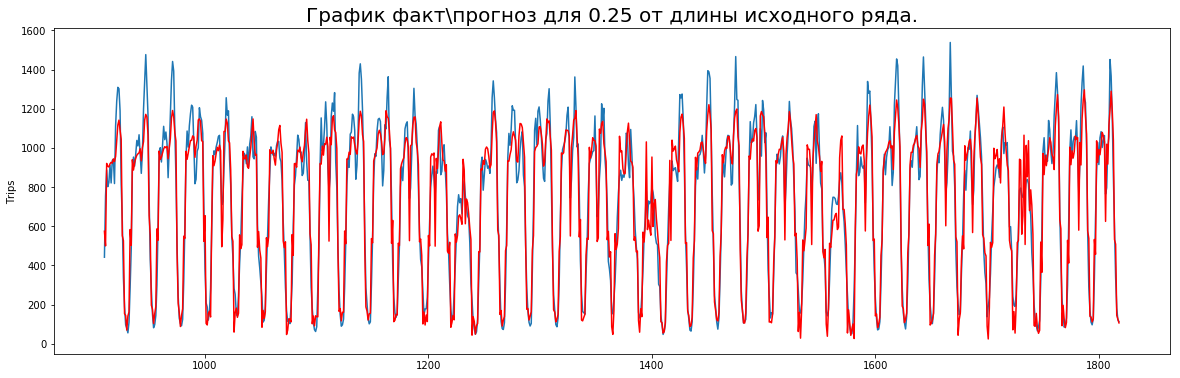

In [87]:
model_2=pd.Series(invboxcox(model.fittedvalues,lmbda),index=data_EBS.index)
plt.figure(figsize(20,6))
data_EBS.N_trips[len(data_EBS)//4:2*len(data_EBS)//4].plot()
model_2[len(data_EBS)//4:2*len(data_EBS)//4].plot(color='r')
plt.ylabel('Trips')
plt.title('График факт\прогноз для 0.25 от длины исходного ряда.',fontsize=20)
pylab.show()

Видим, что к улучшениям это не привело.